# Analyzing data from scrapes...

The MIDAS collection of scraped data contains files from a broad range of COVID public health agencies collected starting in 2020. 
To understand the breadth and variety of tools and practices used, we will analyze these scraped data to understand patterns in data types, file names, and content. Specifically, we will

1. Generate descriptive reports of the range of data types used
2. analyze file names in an attempt to understand patterns in naming 
3. for structured (json, csv, xls, etc.) data, review file contents to identify patterns and to attempt to cluster files into common groups

# Requirements

In [44]:
import json
import pandas as pd
import os
import re
import itertools
import nltk
import sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [45]:
sklearn.show_versions()


System:
    python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 20:33:18)  [Clang 11.1.0 ]
executable: /Users/harry/miniconda3/envs/py39/bin/python
   machine: macOS-13.0.1-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.1.2
          pip: 22.2.2
   setuptools: 65.2.0
        numpy: 1.23.2
        scipy: 1.9.0
       Cython: 0.29.24
       pandas: 1.3.3
   matplotlib: 3.5.1
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /Users/harry/miniconda3/envs/py39/lib/libopenblasp-r0.3.21.dylib
        version: 0.3.21
threading_layer: openmp
   architecture: Haswell
    num_threads: 16

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /Users/harry/miniconda3/envs/py39/lib/libomp.dylib
        version: None
    num_threads: 16


In [46]:
print(nltk.__version__)

3.6.5


In [47]:
print(pd.__version__)

1.3.3


# Build up list of all files. for each, get ID, title, and fileType set

Data extracted from the archive represents each scraping dataset in a JSON blob. We are particularly concerned about the ID, title, and the 'fileTypeSet', which contains information on contained files, as a list.

In [48]:
def read_file(fname):
    with open(fname,'r') as jfile:
        data = json.load(jfile)
    return data

def get_files(path):
    files=[]
    for file in os.listdir(path):
        file =path+"/"+file
        if file.endswith(".json"):
            files.append(file) 
    return files

def get_titles(entry):
    res ={}
    res['fileTypeSet']=entry['fileTypeSet']
    res['metadataCollectionId']=entry['metadataCollectionId']
    res['titleEnglish']=entry['titleEnglish']
    if 'fileSet' in entry:
        res['files'] =[fs['filename'] for fs in entry['fileSet']]
    return res



*Note*: As of December 14, we are working with the original "10_rows" collection. This should probably be revised to use the more complete "10_rows_with_zips" collection

In [49]:
entries = [read_file(fname) for fname in get_files("../10_rows")]
collection = [get_titles(e) for e in entries]


In [50]:
len(collection)

294

In [72]:
cnt = 0
for f in collection:
    if 'files' in f:
        cnt = cnt +len(f['files'])
cnt

354576

Question - how many of these summaries have more than one file type?

In [51]:
type_counts=[len(f['fileTypeSet']) for f in collection]
tcseries = pd.Series(type_counts)
bar  = pd.DataFrame(tcseries.value_counts())
bar

,0
1,148
2,105
3,34
4,6
5,1


<AxesSubplot:>

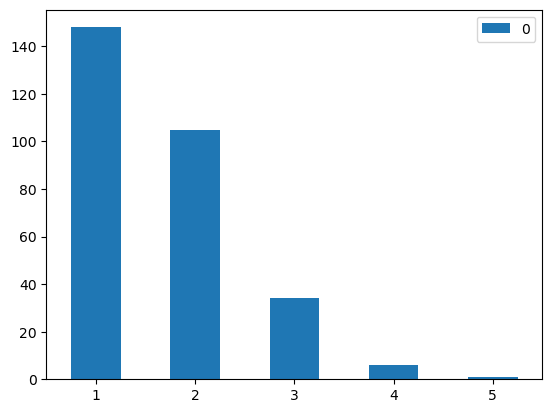

In [52]:
bar.plot(kind="bar",rot=0)

ok. so 146/294, slightly less than 50% have multiple file types

#### look at type distribution - how many have pdf,json,csv, html,png, etc.

In [53]:
type_sum={}
for s in collection:
    ftypes = s['fileTypeSet']
    for ftype in ftypes:
        atype = ftype['fileType']
        if atype not in type_sum:
            type_sum[atype]=0
        type_sum[atype]=type_sum[atype]+1

In [54]:
type_sum

{'html': 78,
 'xlsx': 28,
 'pdf': 47,
 'csv': 132,
 'png': 114,
 'twbx': 5,
 'json': 74,
 'docx': 1,
 'zip': 3,
 'tsv': 1,
 'xls': 2,
 'js': 1,
 'ods': 1,
 'rds': 1,
 'jpg': 1}

In [55]:
counts = list(type_sum.values())
counts

[78, 28, 47, 132, 114, 5, 74, 1, 3, 1, 2, 1, 1, 1, 1]

In [56]:
sum(counts)

489

# <span style='color:red'>*TODO*</span> develop some additional descriptives as necessary to clarify insight

1. Specifically how many sites using tools like Tableau, ArcGIS, or BI
2. How many sites had stayed with one approach vs.  changed over time?
3. Common combinations for sites providing multiple data types?
4. Anything else?

# <span style='color:red'>*TODO*</span> work on identifying and segregating out tableau and other "dashboard" file types - arcgis, Microsoft, BI. We should count them and not use them.


# Filter summaries (and files) by type), then dig into types

In [57]:
def get_entries_by_types(entries,targets):
    res = []
    for e in entries:
        match = False
        fts  = e['fileTypeSet']
        for ft in fts:
            atype = ft['fileType']
            if atype in targets:
                match = True
        if match == True:
            res.append(e)
    return res

def find_entry_by_id(coll,id):
    for ent in coll:
        if ent['metadataCollectionId'] == id:
            return ent
    return None

#  Look at included file names?

In [58]:
def get_titles(entry):
    res ={}
    res['metadataCollectionId']=entry['metadataCollectionId']
    res['titleEnglish']=entry['titleEnglish']
    if 'fileSet' in entry:
        res['files'] =[fs['filename'] for fs in entry['fileSet']]
    return res

Note that we can find the scraping catalog entry for these names at https://catalog.midasnetwork.us/scrapecat/id,
where id is the medatadataCollectionId. 

Thus, we have the link for [collection 816](https://catalog.midasnetwork.us/scrapecat/816)

# PLAN: CLUSTERING ON FILE NAMES

Each of the 200+ sources has a list of files. Our goal will be to do a lexical analysis so that we can tokenize the files, and then to use those tokens to cluster the files via non-negative matrix factorization. We will then use this to see what we can confirm about commonalities or differences between files.

Eventually, we might move from there to do file contents.

Grab all file names

2. Tokenize files by Removing dates, spliting on underscores, splitting on camel case,cleaning other patterns that might be messy
4. Cluster using non-negative matrix factorization (NNMF)
5. Map back from individual items to see what they cluster in
6. Look at the diversity of file names contents within each cluster
7. Add in column names.

For background on NNMF:
* https://predictivehacks.com/topic-modelling-with-nmf-in-python/
* https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8


In [133]:
# ok. Extract name before the date and extension
# split name before the date into indivual words separated by underscore. 
# then further split each by camel case


# a list of patterns that will pull out, for each file name, the key informative tokens and the extension.
# tokens that are time stamps or are otherwise unhelpful are filtered out.
patlist =  [# delaware - 697-has zip codes
            # zip-code-19947-outcomes_2020-10-19_162302.csv'
            # but we will keep these in place, as zip codes are potentially
            # semantically meaningful
        
    
            #'covid-19-raw-data-july-20-2021.xlsx',
            "(.*)-w+-\d{2}-\d{4}.(\w+)$",
            # idaho Sheet_48_Shoshone_2022-02-22_212535.csv
            #  or "Sheet 48"
            "Sheet[\s|_]\d{2}_(.*)_\d{4}-\d{2}-\d{2}_\d{6}.(\w+)$",
            #VDH-COVID-19-PublicUseDataset-Cases_By-Age-Group2020-05-12_12231589300583.csv
            "(.*)\d{4}-\d{2}-\d{2}\_\d+.(\w+)$",
            # 'DC-COVID-19-Data-for-April-05-2021.xlsx'
            "(.*)-\w+-\d{2}-\d{4}.(\w+)$",
            #' illinois_demo_race05_20_2022.csv'
            "(.*)\d{2}_\d{2}_\d{4}.(\w+)$",
            "(.*)[-_]{0,1}\d{4}-\d{2}[-\s]*\d{2}\[_-]\d+.(\w+)$",
            "(.*)_\d{4}-\d{2}-\d{2}_\d{6,}.(\w+)$",
            "(.*)_\d_\d_\d{4}_\d.(\w+)$",
            "(.*)_\d_\d_\d{4}_\d.(\w+)$",
            "(.*)_\d{1,2}_\d{1,2}_\d{4}.(\w+)$",
            "(.*)_\d{1,2}-\d{1,2}-\d{2}_corrected.(\w+)$",
            #COVID-19_OB_weekly_report_7_8_2020_corrected_7-9.xlsx
            "(.*)_\d{1,2}_\d{1,2}_\d{2,4}_corrected_\d{1,2}-\d{1,2}.(\w+)$",
            #covid_outbreak_weekly_report_6-10-20.xlsx,
            "(.*)\_\d{1,2}\-\d{1,2}\-\d{2,4}.(\w+)$",
            # "COVID-19_OB_weekly_report_8_20_2020-2.xlsx"
            "(.*)\_\d{1,2}\_\d{1,2}\_\d{2,4}\-\d.(\w+)$",
            #COVID-19_OB_weekly_report_7_8_2020_corrected_7-9.xlsx            
            "(.*)_\d{1,2}_\d{1,2}_\d{2,4}-corrected_\d{1,2}.(\w+)$",
            #covid_outbreak_weekly_report_5-20-20_.xlsx
            "(.*)_\d{1,2}-\d{1,2}-\d{2,4}_.(\w+)$",
            #colorado_covid-19_outbreaks_2.xlsx
            "(.*)_\d+.(\w+)$",
            #COVID-19_OB_weekly_report_8.5.2020.xlsx
            "(.*)_\d{1,2}.\d{1,2}.\d{2,4}.(\w+)$",
            # syndromic-surveillance-gating-criteria_EXPORT_cases_by_county_covid-19-v2_2020-11-18.csv
            "(.*)_\d{4}-\d{2}-\d{2}.(\w+)$",
            #" NYTIMES names start with dates... 20220407_us.csv', 
            #'20220512_us.csv', '20220512_us-counties.csv', '20220512_us-states.csv'
            "^\d{8}_([^.]+).(\w+)$",
            # ***** FIX -ADD 
            # colorado_covid-19_outbreaks.xlsx   - this one means we'll catch almost anything
            "(.*)\.(\w+)$"
           ]
# turn the patterns into regular expressions.

def precompile_patterns(patlist):
    res = []
    for p in patlist:
        res.append(re.compile(p))
    return res

# iterate through the patterns to find match to the file name. Grab the content part of the file name 
# and the extension
def get_base_match(patterns,fname):
    # try one of several patterns, using the first that matches

    for reg in patterns:
        p = re.compile(reg)
        m = p.match(fname)
        if m is not None:
            break

    try: 
        base_name = m.group(1)
        ext = m.group(2)
        return (base_name,ext)
    except:
        print("can't match..."+fname)

# split camel case entries like "CovidCases" into the constiutent words.
# Note that I don't understand the regexp completely, but it seems to work.
def camel_case_split(str):
    # modified from https://www.geeksforgeeks.org/python-split-camelcase-string-to-individual-strings/
    res = re.findall(r'[A-Z](?:[a-z0-9\-]+|[A-Z0-9\-]*(?=[A-Z0-9\-]|$))', str)
    if len(res) ==0:
        res = [str]
    return res
    
def trim_to_alpha_num(s):
    return ''.join(c for c in s if c.isalnum())

# parse out the tokens and lower-case them
def get_tokens(patterns,fname):

    fname=fname.replace("%20","_")
    (base_name,ext)=get_base_match(patterns,fname)
    base_words_no_camel = re.split(r'\s|_|-',base_name)
    # split by camel case, but not for special -case - those that start with 'TableauTemp'
    #if base_name.startswith('TableauTemp') == False:
    base_words_no_camel = [camel_case_split(bnw) for bnw in base_words_no_camel]
    # flatten the list
    words = list(itertools.chain(*base_words_no_camel))
    # trim to alphanumeric
    words = [trim_to_alpha_num(w) for w in words]
    # tolower 
    words = [w.lower() for w in words]
    # porter stem to get common routes
    return (words,ext)

#def process_collection_files(coll):
#    if 'files' in coll:
#        files = coll['files']
#        coll['processed'] = set([get_tokens(f) for f in files])
#    return coll

# process all of the files in a collection 
def process_collection_files(patterns,coll):
    
    res = []
    if 'files' in coll:
        files = coll['files']
       
        seen={}
        for f in files:
            (words,ext)=get_tokens(patterns,f)
            # now, we have a list of tokens and an extension. need to see if we have seen this one before.
            hash = ''.join(words)+ext
            if hash not in seen:
                seen[hash]=True
                res.append((words,ext))
    return res

# process evertyhing in a collection 
def process_collection(patlist,collection):
    patterns = precompile_patterns(patlist)
    res= []
    for coll in collection:
        processed = process_collection_files(patterns,coll)
        coll['processed']=processed
        res.append(coll)
    return res

In [134]:
proced = process_collection(patlist,collection)

In [135]:
total =0
for p in proced:
    if 'processed' in p:
        total = total + len(p['processed'])

In [136]:
total

7496

In [137]:
ratio = float(total)/float(cnt)

In [138]:
ratio

0.021140742746265963

In [139]:
len(proced)

294

ok. so, 7496 unique patterns across 294.

This includes the possibility that the same pattern might come across in different collections, so the number of unique patterns is likely smalelr

In [140]:
rate = float(total)/294.0
rate

25.496598639455783

average 25.5 items for collection

---- 
Let's get some descriptive.
Frequence of words used?

In [141]:
porter_stemmer = PorterStemmer()
porter_stemmer.stem("vaccination")

'vaccin'

In [142]:
def get_frequencies(proced):
    porter_stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    freqs={}
    types={}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                if ext not in types:
                    types[ext]=0
                types[ext]=types[ext]+1
                for w in words:
                    if w not in stop_words:
                        w = porter_stemmer.stem(w)
                        if w not in freqs:
                            freqs[w]=0
                        freqs[w]=freqs[w]+1
    return (freqs,types)

In [143]:
(freqs,types) = get_frequencies(proced)

In [144]:
len(freqs)

3782

In [145]:
len(types)

5

In [146]:
types

{'xlsx': 527, 'csv': 6964, 'tsv': 1, 'xls': 3, 'ods': 1}

ok. what's up with this. should be more types than these? and numbers seem off?

write a routine to look for items with given extensions. 

 # Some utility routines

In [147]:
def find_processed_by_type(procs,type):
    res=[]
    for p in procs:
        if 'processed' in p:
            ps = p['processed']
            for ent in ps:
                (words,ext) =ent
                if ext == type:
                    res.append(p)
    return res


def find_initial_by_type(procs,type):
    res=[]
    for p in procs:
        if 'files' in p:
            ps = p['files']
            for fname in ps:
                toks = fname.split(".")
                if toks[-1] == type:
                    res.append(p)
    return res

def find_processed_by_term(procs,term):
    res = []
    seen = {}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                for w in words:
                    if w == term:
                        if p['metadataCollectionId'] not in seen:
                            seen[p['metadataCollectionId']] =  True
                            res.append(p)
    return res

def find_tokens_by_term(procs,term):
    seen = {}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                for w in words:
                    if w == term:
                        if p['metadataCollectionId'] not in seen:
                            seen[p['metadataCollectionId']]=[]
                        seen[p['metadataCollectionId']].append(ent)
    return seen

def find_initial_by_substring(procs,substring):
    seen = {}
    for p in proced:
        if 'files' in p:
            for fname in p['files']:
                if fname.find(substring) >=0:
                    if p['metadataCollectionId'] not in seen:
                        seen[p['metadataCollectionId']]=[]
                    seen[p['metadataCollectionId']].append(fname)
    return seen


# ok. find file name by id...

def get_entry_by_id(plist,id):
    for p in plist:
        if p['metadataCollectionId'] == id:
            return p
    return None

def get_file_names_by_entry_and_string(plist,id,str_val):
    res =[]
    ent = get_entry_by_id(plist,id)
    if ent is None:
        return None
    for fname  in ent['files']:
        if fname.find(str_val) > 0:
            res.append(str_val)
    return res

def find_file_names_with_string(plist,str_val):
    res ={}
    for p in plist:
        id = p['metadataCollectionId']
        if 'files' in p:
            matches=[]
            for fname in p['files']:
                if fname.find(str_val)> 0:
                    matches.append(fname)
            if len(matches) > 0:
                res[id]=matches
    return res

 # Filtering out "noisy" or uninformative tokens

let's look at descriptives on words

# <span style='color:red'>*TODO*</span> work on filtering out uninformativer tokens. Ideally, do this by improving the regular expressions above. Alternatively, look at post-filtering.


# Look at frequently found terms

In [148]:
topfreqs = sorted(freqs.items(),key=lambda x:x[1],reverse=True)
sfreqs=dict(topfreqs[:100])

In [149]:
len(sfreqs)

100

In [170]:
sfreqs

{'': 7349,
 'temp': 6127,
 'tableau': 3101,
 'extract': 2972,
 'counti': 1585,
 'death': 794,
 'age': 781,
 'covid': 723,
 'data': 678,
 '19': 666,
 'vaccin': 664,
 'race': 479,
 'peopl': 463,
 'demograph': 415,
 'date': 377,
 'case': 350,
 'dc': 312,
 'cti': 288,
 'gender': 265,
 'eth': 237,
 'daili': 235,
 'pc': 232,
 'time': 229,
 'test': 226,
 'sex': 219,
 'seri': 219,
 'dose': 216,
 'complet': 211,
 '2021': 205,
 'zip': 191,
 'curv': 189,
 'feder': 181,
 'code': 179,
 'epi': 178,
 'ethnic': 175,
 'dashboard': 175,
 'rate': 158,
 'file': 138,
 'booster': 133,
 'twb': 132,
 'raw': 131,
 'pcr': 118,
 '1': 111,
 'onset': 110,
 '2': 108,
 'mortal': 103,
 '2020': 99,
 'new': 77,
 'wy': 72,
 'rc': 65,
 'count': 63,
 'total': 63,
 'group': 62,
 'd9': 62,
 'updat': 61,
 'state': 60,
 'number': 60,
 'sqlproxi': 57,
 'averag': 57,
 '22': 57,
 'demo': 55,
 '3': 51,
 'posit': 50,
 '6': 49,
 '4': 47,
 'may': 47,
 'd1': 46,
 'f1': 46,
 'de95cb654114adc9b8ad7ca5347a': 46,
 'result': 46,
 'adadaa4

1. Can we do a histogram? 
2. What's with DE95CB654114ADC9B8AD7CA5347A, ADADAA42C5A75DBE52BF8C2EBC,  or 0crbell165o69810qb23000ksfyl or 10bozup0k69eqi1a0wz3j172f732, etc.?

In [157]:
de95s = find_processed_by_term(proced,'DE95CB654114ADC9B8AD7CA5347A')
len(de95s)

0

DE95... looks like a repeated name..from tableau extracts?

In [158]:
crbells = find_processed_by_term(proced,'0crbell165o69810qb23000ksfyl')
len(crbells)

1

looking into crbell[0] - also looks like tableau

looks like empty string or '1' could be legit, as some files have '-', and '_1_"...

Questions for Anne:
    
    1. Are the "07jp3yg1rhy0bj1essrgm1ezzkur" files legit names from tableau?
    2. Did she not give me file names for json, etc? Can i get those json?

# look for patterns that might be inappropriate. filter them out

In [165]:
t1 = find_processed_by_term(proced,'ju')
len(t1)

0

In [166]:
ids = [p['metadataCollectionId'] for p in t1]
ids

[]

In [164]:
t1[0]['titleEnglish']

IndexError: list index out of range

In [ ]:
matches =  get_file_names_by_entry_and_string(proced,836,'rc')
matches

In [ ]:
e864=get_entry_by_id(proced,864)

In [ ]:
files = [fname for fname in e864['files'] if fname.find('rc') >0 ]

In [ ]:
files[:10]

In [167]:
test=julis[815][0]
test

'covid-19-raw-data-july-23-2021.xlsx'

In [172]:
t1 = find_processed_by_term(proced,'cti')
len(t1)

0

In [174]:
ctis=find_file_names_with_string(proced,'cti')
ctis

{695: ['data_dictionary_covid_19_cases_by_zip_2020-10-22_162302.xlsx',
  'data_dictionary_highest50_population_zip_codes_2020-10-22_162302.xlsx'],
 800: ['data_dictionary_2020-06-25_21261593134765.csv',
  'data_dictionary_2020-06-26_12511593190289.csv',
  'data_dictionary_2020-10-22_162302.csv'],
 699: ['covid_report_county_date_datadictionary_2020-08-27_002302.xlsx',
  'covid_report_county_date_datadictionary_2022-02-25_082302.xlsx',
  'covid_report_county_date_datadictionary_2022-03-31_162302.xlsx',
  'covid_report_county_date_datadictionary_2020-10-22_162302.xlsx',
  'covid_report_county_date_datadictionary_2020-12-31_122303.xlsx',
  'covid_report_county_date_datadictionary_2020-09-25_122320.xlsx',
  'covid_report_county_date_datadictionary_2020-08-20_202311.xlsx'],
 749: ['TexasCOVID-19ActiveCaseDatabyCounty_2021-09-14_122303.xlsx',
  'TexasCOVID-19ActiveCaseDatabyCounty_2020-10-06_162304.xlsx',
  'TexasCOVID-19ActiveCaseDatabyCounty_2021-09-03_162303.xlsx',
  'TexasCOVID-19ActiveC

----
# Summary of patterns
*  "zip-code-19947-outcomes_2020-10-19_162302.csv" - we will keep the zip code ("19947") as a semantically-meaningful component
* Idaho has "sheet_48" patterns - Sheet_48_Teton_2022-03-23_212308.csv  - filter those out.
* Arizona has files that start with 'RC' not clear why
* Strings that come up in Tableau files that we can work on
** jul

# Open Questions

* can we find a way to remove geographic locations?
